In [117]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plot
import pycaret.classification as pycaret_classification
import mlflow

from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import log_loss, f1_score



# Configurar o MLFLOW

In [166]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Lançamentos do Kobe Bryant'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/Users/rafael/dev/workspaces/infnet/pos-ai/machine-learning-engeneering/projeto-final-ml-eng/code/mlruns/1', creation_time=1712428469138, experiment_id='1', last_update_time=1712428469138, lifecycle_stage='active', name='Lançamentos do Kobe Bryant', tags={}>

# Preparação e análise do experimento

## Processa os dados de entrada

In [168]:
# Essas são as colunas que serão usadas nos experimentos a seguir
colunas = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
colunas_sem_alvo = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance']
coluna_alvo= 'shot_made_flag'

percentual_treinamento = 0.8

#Começa o experimento
with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados', nested=True):  
    dataframe_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

    # Remove as linhas com campos nulos e copia o dataframe resultante selecionando apenas as colunas importantes para o experimento.
    dataframe_dev = dataframe_dev.dropna()
    dataframe_dev = dataframe_dev[colunas].copy()

    dataframe_dev.to_parquet('../data/processed/data_filtered.parquet')

    xtrain, xtest, ytrain, ytest = train_test_split(dataframe_dev[colunas_sem_alvo], 
                                                    dataframe_dev[coluna_alvo], 
                                                    train_size=percentual_treinamento, 
                                                    stratify=dataframe_dev[coluna_alvo]
                                                   )

    xtrain[coluna_alvo] = ytrain
    xtest[coluna_alvo] = ytest

    # Exporta bases de treino e teste
    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')
    
    mlflow.log_params({
        'percentual_teste': 1-percentual_treinamento,
        'colunas-selecionadas': colunas
    })
    mlflow.log_metrics({
        'quantidade_linhas_treino': xtrain.shape[0],
        'quantidade_linhas_teste': xtest.shape[0]
    })
    
mlflow_run = mlflow.active_run()


## Configura o pycaret

In [170]:
# configura pycaret
experiment = pycaret_classification.setup(
    data = xtrain, 
    target = coluna_alvo, 
    test_data = xtest, 
    normalize = True, 
    log_experiment = False
)

# Os modelos utilizados são regressão logística (lr) e árvore de decisão (dt)
modelos_utilizados = ['lr', 'dt']

list_models = experiment.compare_models(modelos_utilizados, n_select = 2)

list_models

,Description,Value
0,Session id,908
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5760,0.5978,0.4848,0.5654,0.5219,0.1451,0.1465,0.0150
dt,Decision Tree Classifier,0.5394,0.5208,0.5750,0.5158,0.5437,0.0814,0.0820,0.1640


[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=908, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        random_state=908, splitter='best')]

In [172]:
# plot com a validation curve "vc" e salva a imagem
experiment.plot_model(list_models[0], plot='vc', save = True)

# Cria função para plotar a calidation curve especificando o parametro
def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plot.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plot.title("Curva Validação Modelo " + model_name)
    plot.xlabel(param_name)
    plot.ylabel("Score ("+scoring+")")
    if logx:
        plot.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plot.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plot.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plot.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plot.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plot.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plot.legend(loc='best')
    plot.grid(True)
    
    image = plot.gcf()
    image_name = 'validation_curve' + '_' + model_name + '_' + param_name + '.png'
    image.savefig(image_name, dpi=100)
    plot.show()
    return image_name


## Registra regressão logistica

In [173]:
yhat_test = experiment.predict_model(list_models[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5807,0.6023,0.4992,0.5695,0.5320,0.1552,0.1563


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


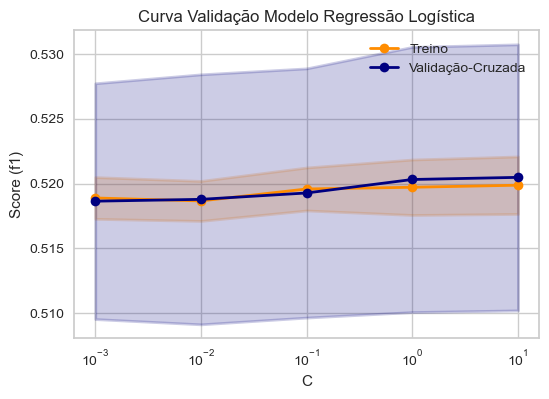

In [176]:
image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]}, list_models[0], 'Regressão Logística', 'f1', logx=True)

mlflow.log_artifact(image_name, run_id=mlflow_run.info.run_id)

os.remove(image_name)

mlflow.log_metrics({
'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
})

# Registra árvore de decisão

In [178]:
yhat_test = experiment.predict_model(list_models[1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5386,0.5173,0.5932,0.5146,0.5511,0.0813,0.0822


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


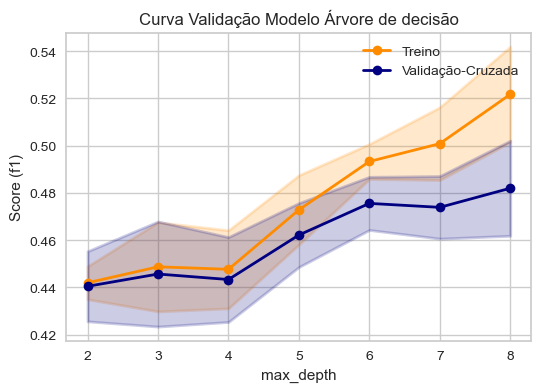

In [180]:
image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]}, list_models[1], 'Árvore de decisão', 'f1', logx=False)

mlflow.log_artifact(image_name)

os.remove(image_name)

mlflow.log_metrics({
'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
})

# Treinamento do modelo

In [186]:
with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    # configura pycaret
    experiment = pycaret_classification.setup(
        data = xtrain, 
        target = coluna_alvo, 
        test_data = xtest, 
        normalize = True, 
        log_experiment = False
    )

    # Os modelos utilizados são regressão logística (lr) e árvore de decisão (dt)
    modelos_utilizados = ['lr', 'dt']

    list_models = experiment.compare_models(modelos_utilizados, n_select = 2)

    list_models
    
    # Regressão Logística
    yhat_test = experiment.predict_model(list_models[0])
    lr_image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]}, list_models[0], 'Regressão Logística', 'f1', logx=True)

    mlflow.log_artifact(lr_image_name, run_id=mlflow_run.info.run_id)

    os.remove(lr_image_name)

    mlflow.log_metrics({
    'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    # Árvore de decisão
    yhat_test = experiment.predict_model(list_models[1])
    
    dt_image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]}, list_models[1], 'Árvore de decisão', 'f1', logx=False)

    mlflow.log_artifact(dt_image_name)

    os.remove(dt_image_name)

    mlflow.log_metrics({
    'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    # Finaliza o melhor modelo ( Regressão Logística)
#    tune_model = experiment.tune_model(model)
    
    

Exception: Run with UUID a6577835d02344908f27ee3d53f587b0 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

# Reset do estilo de cores do matplotlib 

In [6]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)


# Detalhamento dos passos do projeto


In [8]:
registered_model_name = 'modelo_lancamento_kobe'
min_precision = 0.7
model_version = -1 # recuperar a ultima versao
nexamples = 4

# Experimento de Classificação de Lançamentos

In [20]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Experimento de Lançamentos Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

# Leitura dos Dados de Classificação de Lançamentos 

In [ ]:
# COLOCAR RUN DE LEITURA DE DADOS
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum

top_features = ['lat','lon','minutes remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    df_wine = pd.read_csv('../data/data.csv',sep=',')
    shot_target_col = 'shot_made_flag'
    wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()
    drop_cols = ['target_label']
    df_wine.drop(drop_cols, axis=1, inplace=True)
    df_wine = df_wine[top_features + ['type', shot_target_col]].copy()

    data_wine = df_wine[df_wine['type'] == 'red'].copy().drop('type', axis=1)
    # Separar parte para compor a base de operacao
    data_wine, data_operation, ytrain, ytest = model_selection.train_test_split(data_wine, 
                                                                            data_wine[shot_target_col],
                                                                            test_size=0.2)
    data_wine[shot_target_col]      = ytrain
    data_operation[shot_target_col] = ytest

    # Base de vinhos brancos
    data_novelty = df_wine[df_wine['type'] == 'white'].copy().drop('type', axis=1)

    data_novelty.to_parquet('modelo_vinho_novidade.parquet')
    data_operation.to_parquet('modelo_vinho_operacao.parquet')
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("top_features", top_features)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("data_dev", data_wine.shape[0])
    mlflow.log_metric("data_operation", data_operation.shape[0])
    mlflow.log_metric("data_novelty", data_novelty.shape[0])
   
    
mlflow.end_run()

print('== Bases de Dados ==')
print(f'data_wine {data_wine.shape}')
print(f'data_operation {data_operation.shape}')
print(f'data_novelty {data_novelty.shape}')
print(f'Columns: {data_wine.columns}')